<a href="https://colab.research.google.com/github/gowtham66866/Inkers/blob/master/Gowtham_Assignment_6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.utils import np_utils


# Multiple Inputs
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D,SeparableConv2D,DepthwiseConv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

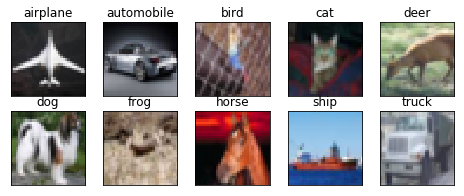

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

Spacial separable convolution has been added at third convolution block's second convolution layer. Number of parameters for this layer 3x1x256x256+1x3x256x256 adding bias parameters we get the number 196864+196864 parameters shown in the summary of keras model. Compared to original 3x3 conv2D layer which has 3x3x256x256 has 1.5 times more parameters compared to our spacially separable convolution.


Depthwise seperable convolution:
Added spacial separable convolution, at fifth convolution block's second convolution layer. Number of parameters for this layer 3x3x512+1x1x512x512 adding bias parameters (512) we get the number 267264 parameters shown in the summary of keras model. SeparableConv2D performs depthwise convolution followed by pointwise convolution here. This leads to saving of parameters compared to normal 3x3 convolution which has 3x3x512x512 which has 8.82 times more numer of parameters compared to Depthwise seperable convolution.


Grouped convolution:


*   Two grouped convolutions the network has been used. Each group convolution layer has two parallel convoution layers.
*   In Second and fourth convolution blocks have grouped convolutions.

*   Grouped convolution has been to make sure that early feature and later features are used together for the training process. 
*   Grouped convolution in the second convolution block has been used for  two parallel convolution blocks, with one the blocks using a dilated convolution with a dialation rate of 2. This means that the kernel of 3x3 will have a receptive field effect of 5x5 with the kernel coverate area spread out with a gap of one pixel surrounding each kernel element. This is good for global feature extraction. For another parallel layer we use a  dilation rate of 1  which is nothing but a normal convolution layer.

*   Parallel layers of grouped convolution is concatinated here. This will increase the number of channels. 1x1 or pointwise convolutionhas been used to reduce the number of channels.
*   We are using Grouped convolution in the fouth convolution block is using two parallel convolution blocks, it has only three simple 3x3 and 5x5 convolution layers.







With all the parallel layers of grouped convolutions the parameter count as gone up substancially to 13 Million. We need to fine tune the network, to reduce the number of parameters in future. Aim of this notebook is to only add different types of convolutions specified above, but not for parameter efficiency or better accuracy.

After training the network for 100 epoch, validation acc of 72.73% has been arrived and a training acc of 86.38% which is an improvement on the baseline of val_acc: 0.8340.

In [7]:
weight_decay = 0.005

# Input layer
img = Input(shape=(32,32,3))

# 1st convolution block
x = Conv2D(64, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(img) #32
x = BatchNormalization()(x)
x = Dropout(0.4)(x)  
x = Conv2D(64, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #32
x = BatchNormalization()(x)
x = Dropout(0.4)(x) 

# 1st transition block with bottlneck
x = MaxPooling2D(pool_size=(2, 2))(x) #16
x = Conv2D(64, kernel_size=1, activation='relu')(x)



# 2nd convolution block
#******************************************GROUPED CONVOLUTION*************
x = Conv2D(128, kernel_size=3, padding='same',dilation_rate=(1, 1), activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #16
x = BatchNormalization()(x)
x = Dropout(0.4)(x) 

# Dilated Convolutino with dilation rate of 2
x1 = Conv2D(512, kernel_size=3, padding='same', dilation_rate=(2, 2), activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #4
x1 = BatchNormalization()(x1)
x1 = Dropout(0.4)(x1)

x = concatenate([x1, x])
x = Conv2D(512, kernel_size=1, activation='relu')(x)
#*******************************************************************************
x = Conv2D(128, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #16
x = BatchNormalization()(x)
x = Dropout(0.4)(x) 

# 2nd transition block with bottlneck
x = MaxPooling2D(pool_size=(2, 2))(x) #8
x = Conv2D(64, kernel_size=1, activation='relu')(x)


# 3rd convolution block
x = Conv2D(256, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #8
x = BatchNormalization()(x)
x = Dropout(0.4)(x)  
# ******************Spacial Separable convolution****************************
# x = Conv2D(256, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #8
x = Conv2D(256, kernel_size=(3,1), padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #8
x = Conv2D(256, kernel_size=(1,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #8
# **************************************************************************************
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Conv2D(256, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #8
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# 3rd transition block with bottlneck
x = MaxPooling2D(pool_size=(2, 2))(x) #4
x = Conv2D(64, kernel_size=1, activation='relu')(x)

# 4th convolution block
#******************************************GROUPED CONVOLUTION*************
x = Conv2D(512, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #4
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x1 = Conv2D(512, kernel_size=5, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #4
x1 = BatchNormalization()(x1)
x1 = Dropout(0.4)(x1)


x = Conv2D(512, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #4
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# print("test",np.shape(concatenate([x1, x])))

x = concatenate([x1, x])
x = Conv2D(512, kernel_size=1, activation='relu')(x)
#****************************************************************************************


# 4th transition block with bottlneck
x = MaxPooling2D(pool_size=(2, 2))(x) #2
x = Conv2D(64, kernel_size=1, activation='relu')(x)

# 5th convolution block
x = Conv2D(512, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #2
x = BatchNormalization()(x)
x = Dropout(0.4)(x)  
# ***************************Depthwise seperable convolution **************************
x = SeparableConv2D(512, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #2
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# 5th transition block with bottlneck
x = MaxPooling2D(pool_size=(2, 2))(x) #1
x = Conv2D(64, kernel_size=1, activation='relu')(x)


# final convolution block
x = Conv2D(512, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #1
x = BatchNormalization()(x)
x = Dropout(0.4)(x)  
x = Conv2D(10, kernel_size=3, padding='same')(x) #1

x = Flatten()(x)
output = Activation('softmax')(x)


model = Model(inputs=[img], outputs=output)
# summarize layers
print(model.summary())

W0615 19:14:46.606175 140554760185728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0615 19:14:46.627768 140554760185728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0615 19:14:46.635234 140554760185728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0615 19:14:46.672073 140554760185728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0615 19:14:46.676625 1405547601

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [9]:
from keras.optimizers import adam
adam = adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8,decay=0.005)
model.compile(loss='categorical_crossentropy',
             optimizer=adam,
             metrics=['accuracy'])

W0615 19:14:49.833743 140554760185728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':
W0615 19:14:50.253004 140554760185728 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will

Epoch 1/50
390/390 [==============================] - 168s 430ms/step - loss: 8.5729 - acc: 0.1840 - val_loss: 3.3968 - val_acc: 0.1000
Epoch 2/50
390/390 [==============================] - 152s 391ms/step - loss: 2.5588 - acc: 0.2111 - val_loss: 2.7175 - val_acc: 0.1012
Epoch 3/50
390/390 [==============================] - 147s 377ms/step - loss: 2.2188 - acc: 0.2553 - val_loss: 2.5633 - val_acc: 0.1651
Epoch 4/50
390/390 [==============================] - 147s 377ms/step - loss: 2.0942 - acc: 0.3219 - val_loss: 2.1992 - val_acc: 0.3078
Epoch 5/50
390/390 [==============================] - 147s 377ms/step - loss: 1.9137 - acc: 0.3962 - val_loss: 2.2887 - val_acc: 0.2471
Epoch 6/50
390/390 [==============================] - 147s 377ms/step - loss: 1.7977 - acc: 0.4508 - val_loss: 1.9940 - val_acc: 0.3826
Epoch 7/50
390/390 [==============================] - 147s 378ms/step - loss: 1.6972 - acc: 0.4879 - val_loss: 2.0225 - val_acc: 0.3587
Epoch 8/50
390/390 [============================

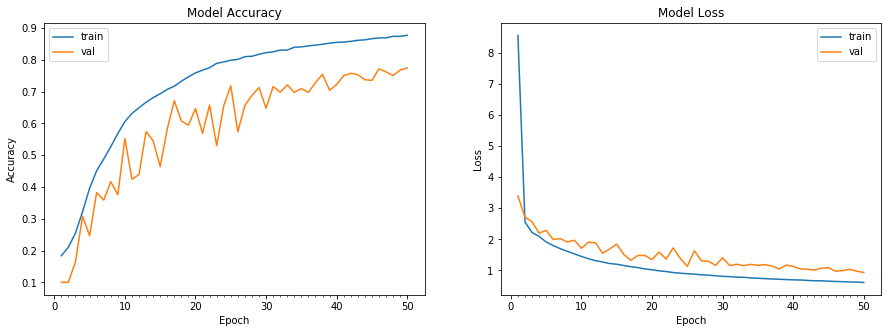

Accuracy on test data is: 77.40


In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))